In [4]:
import rank
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import spectral_clustering
from sklearn import metrics
from scipy.stats import spearmanr
import math
%matplotlib inline
np.random.seed(10)

Three Group Hierarchy
=============

Scores drawn from three normal distribution: N(-4, 2), N(0, 0.5), N(4, 1), Beta [0.1, 5] and C so that average degree is 5. 

Figure 3: A plot of clustering errors (homogeneity and completeness score -- the closer to 1 the better, 0 is as bad as possible) for each Beta.

Figure 2a & b: Clustering of scores for a low and a high Beta value.

Figure 1: Correlation matrix of graph

In [ ]:
#Replicate Dan's results
#Adding the clustering
reps = 100
n = 102
trials=10
avg_degree = 5 
beta_list = np.arange(0.1, 2.1, 0.1)
bs = beta_list.size
groups = np.concatenate((np.repeat(0, int(102/3)), np.repeat(1, int(102/3)), np.repeat(2, int(102/3))))

spearman_corel = np.zeros((bs, reps)) 

homogeneity = np.zeros((bs, reps)) #measures of quality of clusters
completeness = np.zeros((bs, reps))
vmeasure = np.zeros((bs, reps))

homogeneity_scr = np.zeros((bs, reps))
completeness_scr = np.zeros((bs, reps))
vmeasure_scr = np.zeros((bs, reps))

n_cluster_list = np.zeros((bs, reps))
n_cluster_list_scr = np.zeros((bs, reps))

correlations = np.zeros((bs,n,n))
ranks = np.zeros((bs,n))

for r in range(reps):
    #plant ranks
    scores = np.concatenate((np.random.normal(-4, math.sqrt(2), size=int(n/3)), 
                         np.random.normal(0, math.sqrt(0.5),size=int(n/3)), 
                         np.random.normal(4, math.sqrt(1), size=int(n/3))))
    #spring energy matrix
    spr = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            spr[i,j] = (scores[i] - scores[j] - 1)**2
            
    for i in range(bs):
        #plant graph
        beta = beta_list[i]
        c = avg_degree*n/np.sum(np.exp(-0.5*beta*spr))
        A = rank.generate_graph(s=scores, beta=beta, c=c)
        
        #calculate ranks
        out = rank.spring_rank(A)
        scores_pred = out[0]
        
        #compare to planted ranks
        spearman_corel[i, r] = spearmanr(scores, scores_pred)[0]
        
        #correlation between ranks
        sigma = out[1]
        correlation = rank.pearson_correlation(sigma)
        
        if r==1:
            correlations[i,:,:] = correlation
            ranks[i,:] = scores_pred
        
        #cluster the correlation and predicted scores
        features = [correlation, scores_pred.reshape((n,1))]
        for m in range(2):
#choose number of clusters using silhouette scores        
#             ss = np.zeros(trials)
#             for k in range(1,trials):
#                 kmeans = KMeans(n_clusters=k+1, random_state=0).fit(features[m])
#                 ss[k] = metrics.silhouette_score(features[m], kmeans.labels_)
#             n_clusters = int(np.argmax(ss) + 1)

            n_clusters = 3
            
            #cluster:
            kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features[m])
            groups_pred = kmeans.labels_

            #measure quality of clusters
            if m == 0:
                homogeneity[i, r] = metrics.homogeneity_score(groups, groups_pred)  
                completeness[i, r] = metrics.completeness_score(groups, groups_pred)
                vmeasure[i, r] = metrics.v_measure_score(groups, groups_pred)
                n_cluster_list[i, r] = n_clusters
            else:
                homogeneity_scr[i, r] = metrics.homogeneity_score(groups, groups_pred)  
                completeness_scr[i, r] = metrics.completeness_score(groups, groups_pred)
                vmeasure_scr[i, r] = metrics.v_measure_score(groups, groups_pred)
                n_cluster_list_scr[i, r] = n_clusters
        

In [72]:
#Save data:
#Source:https://stackoverflow.com/questions/25749215/save-a-numpy-matrix
# np.savez('three_group_data', spearmanr=spearman_corel, crl_homogeneity=homogeneity, crl_completeness=completeness, 
#          crl_vmeasure=vmeasure, scr_homogeneity=homogeneity_scr, scr_completeness=completeness_scr, scr_vmeasure=vmeasure_scr,
#         n_clusters = n_cluster_list, scr_n_clusters= n_cluster_list_scr,
#         correlations=correlations, rankings=rankings)

PLOT
----

In [77]:
data = np.load('three_group_data_8-7.npz')

In [78]:
reps=100
error1 = np.std(data['crl_homogeneity'], axis=1)/math.sqrt(reps) #std of row
error2 = np.std(data['crl_completeness'], axis=1)/math.sqrt(reps)
error3 = np.std(data['scr_homogeneity'], axis=1)/math.sqrt(reps)
error4 = np.std(data['scr_completeness'], axis=1)/math.sqrt(reps)

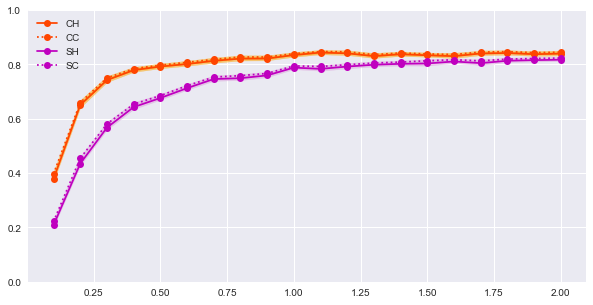

In [79]:
#Clustering Homogeneity and Completeness for different beta
#source https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
#error band: https://stackoverflow.com/questions/12957582/matplotlib-plot-yerr-xerr-as-shaded-region-rather-than-error-bars
f, ax = plt.subplots(figsize=(10,5))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax.plot(beta_list, np.mean(data['crl_homogeneity'], axis=1), marker='o', label='CH', color='orangered')
ax.plot(beta_list, np.mean(data['crl_completeness'], axis=1), marker='o', ls='dotted', label='CC', color='orangered')
ax.plot(beta_list, np.mean(data['scr_homogeneity'], axis=1), marker='o', label='SH', color='m')
ax.plot(beta_list, np.mean(data['scr_completeness'], axis=1), marker='o', ls='dotted', label='SC', color='m')
plt.fill_between(beta_list, np.mean(data['crl_homogeneity'], axis=1)-error1, np.mean(data['crl_homogeneity'], axis=1)+error1, alpha=0.5,color='orange')
plt.fill_between(beta_list, np.mean(data['crl_completeness'], axis=1)-error2, np.mean(data['crl_completeness'], axis=1)+error2, alpha=0.5, color='orange')
plt.fill_between(beta_list, np.mean(data['scr_homogeneity'], axis=1)-error3, np.mean(data['scr_homogeneity'], axis=1)+error3, alpha=0.5, color='plum')
plt.fill_between(beta_list, np.mean(data['scr_completeness'], axis=1)-error4, np.mean(data['scr_completeness'], axis=1)+error4, alpha=0.5, color='plum')
ax.set_ylim([0,1])
ax.legend()
plt.savefig('presentation/images/three group/clustering_performance_over_beta2_dashed.png')

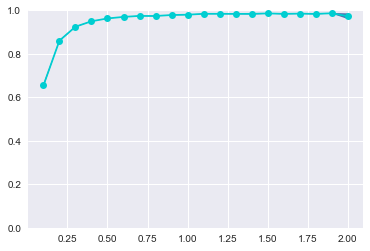

In [65]:
# Spearman Correlation
error5 = np.std(data['spearmanr'], axis=1)/math.sqrt(reps)
plt.plot(beta_list, np.mean(data['spearmanr'], axis=1), color='darkturquoise', marker='o')
plt.fill_between(beta_list, np.mean(data['spearmanr'], axis=1)-error5, np.mean(data['spearmanr'], axis=1)+error5)
plt.ylim([0,1])
plt.savefig('presentation/images/three group/spearmanr_over_beta2.png')

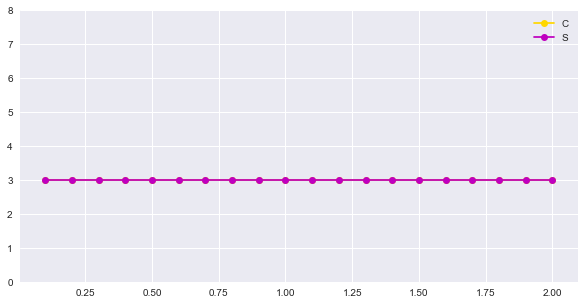

In [66]:
# Is the clustering by correlation underfitting because homogeneity is low (cluster only has member of a class) 
#but completeness is high (all members of class in same cluster)?
error6 = np.std(data['n_clusters'], axis=1)/math.sqrt(reps)
error7 = np.std(data['scr_n_clusters'], axis=1)/math.sqrt(reps)
f, ax = plt.subplots(figsize=(10,5))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax.plot(beta_list, np.mean(data['n_clusters'], axis=1), marker='o', color='gold', label='C')
ax.plot(beta_list, np.mean(data['scr_n_clusters'], axis=1), marker='o', color='m', label='S')
plt.fill_between(beta_list, np.mean(data['n_clusters'], axis=1)-error6, np.mean(data['n_clusters'], axis=1)+error6, alpha=0.7, color='khaki')
plt.fill_between(beta_list, np.mean(data['scr_n_clusters'], axis=1)-error7, np.mean(data['scr_n_clusters'], axis=1)+error7, alpha=0.7, color='plum')
ax.legend()
ax.set_ylim([0,8])
plt.savefig('presentation/images/three group/number_clusters_over_beta2.png')

In [55]:
#Plot correlation matrix
for k in range(data['correlations'].shape[0]):
    plt.matshow(data['correlations'][k,:,:], cmap='RdBu_r');
    plt.colorbar();
    plt.savefig('presentation/images/three group/correlation/beta'+str(k)+'.png')
    plt.clf()

In [53]:
#Plot the density of scores
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
ranks = np.load('three_group_ranks_8-6.npy')
for i in range(ranks.shape[0]):
    X = ranks[i,:][:, np.newaxis]
    X_plot = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
    fig, ax = plt.subplots()
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot) 
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format('gaussian'))
    plt.savefig('presentation/images/three group/scores_dist_beta'+str(i)+'.png')
    plt.clf()


Plot an example of a tier graph with 100 nodes
---------------
PLOTLY doesn't work because it only create straight edges.

TODO: find another package?